## 싸인 함수 회귀분석 (Sine Regression)

In [6]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

#### Package Import

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__) 

2.3.0


## 데이터 생성

#### Spiral Data Generation 함수 정의

In [8]:
theta = 4

# generate the data
def generate_spiral_dataset(num_data, num_class, num_dim=2):
    input_data = np.zeros((num_data*num_class,num_dim)) # data matrix (each row = single example)
    output_data = np.zeros(num_data*num_class, dtype='uint8') # class labels

    for j in range(num_class):
      ix = range(num_data*j,num_data*(j+1))
      r = np.linspace(0.0,1,num_data) # radius [0,1]
      t = np.linspace(j*theta,(j+1)*theta,num_data) + np.random.randn(num_data)*0.2 # theta [0, 4]
      input_data[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
      output_data[ix] = j
    
    return input_data, output_data

#### 훈련 데이터, 테스트 데이터 생성

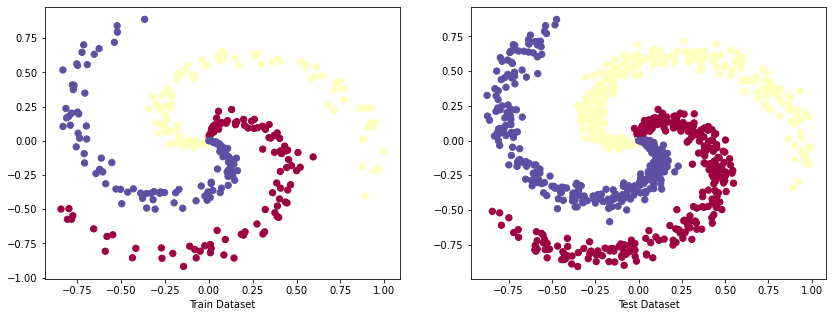

In [9]:
N = 100 # 각각의 class에는 100개의 data가 존재한다
D = 2 # 각각의 data는 2차원 형태이다(점의 좌표는 2차원)
K = 3 # class의 수를 의미하며, spiral_dataset은 3가지의 class를 가진다

train_x, train_y = generate_spiral_dataset(N, K, D) 
test_x, test_y = generate_spiral_dataset(N*3, K, D)

# lets visualize the data:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.scatter(train_x[:, 0], train_x[:, 1], c=train_y, s=40, cmap=plt.cm.Spectral)
plt.xlabel("Train Dataset")
plt.subplot(1,2,2)
plt.scatter(test_x[:, 0], test_x[:, 1], c=test_y, s=40, cmap=plt.cm.Spectral)
plt.xlabel("Test Dataset")
plt.show()

## 모델 정의

In [10]:
# 모델은 tensorflow를 이용하여 만든다
# 여기서는 model 계층을 만들지 않고 가중치와 편향을 직접 입력하여 모델을 만든다.

class Model(tf.Module):
    def __init__(self):
        # dnn_sine_regression문제와 구조는 비슷하므로 자세한 설명은 생략
        initializer = tf.initializers.GlorotUniform()
        W0 = tf.Variable(initializer(shape=[D, 20]), dtype=tf.float32, name='W0')  #input layer는 D차원이다
        W1 = tf.Variable(initializer(shape=[20, 20]), dtype=tf.float32, name='W1')
        W2 = tf.Variable(initializer(shape=[20, K]), dtype=tf.float32, name='W2') # output layer는 K개의 class를 가진다

        b0 = tf.Variable(tf.zeros(shape=[20]), dtype=tf.float32, name='b0')
        b1 = tf.Variable(tf.zeros(shape=[20]), dtype=tf.float32, name='b1')
        b2 = tf.Variable(tf.zeros(shape=[K]), dtype=tf.float32, name='b2')

        self.weights = [W0, W1, W2]
        self.biases = [b0, b1, b2]
        self.activations = [tf.nn.relu, tf.nn.relu, None]
    
    def __call__(self, x):
        layer = x
        for W, b, activation in zip(self.weights, self.biases, self.activations):
            layer = tf.matmul(layer, W) + b
            if activation is not None:
                layer = activation(layer)
        output_pred = layer
    
        return output_pred

## 모델 훈련

### one-hot encoding


In [11]:
model = Model()
optimizer = tf.optimizers.Adam() # create optimizer

# run training
batch_size = 32
for training_step in range(10000):
    # get a random subset of the training data
    indices = np.random.randint(low=0, high=len(train_x), size=batch_size)
    input_batch = tf.Variable(train_x[indices], dtype=tf.float32, name='input')
    output_batch = tf.Variable(train_y[indices], dtype=tf.uint8, name='output')
    output_batch = tf.one_hot(output_batch, K) # one-hot encoding
    # output_batch를 one-hot encoding한 것이 target값이다

    with tf.GradientTape() as tape:
        # model(input_batch) : model에서 predict한 결과값이다
        output_pred = model(input_batch)
        # 현재, classification 문제 => cross_entropy loss 사용[tf.nn.softmax_cross_entropy_with_logits 이용]
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(output_batch, output_pred))

        # gradient계산
        grads  = tape.gradient(loss, model.trainable_variables)
        # model parameter update
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
    if training_step % 1000 == 0:
        print('{0:04d} loss: {1:.3f}'.format(training_step, loss.numpy()))

0000 loss: 1.092
1000 loss: 0.154
2000 loss: 0.066
3000 loss: 0.044
4000 loss: 0.054
5000 loss: 0.018
6000 loss: 0.076
7000 loss: 0.006
8000 loss: 0.003
9000 loss: 0.000


## 테스트

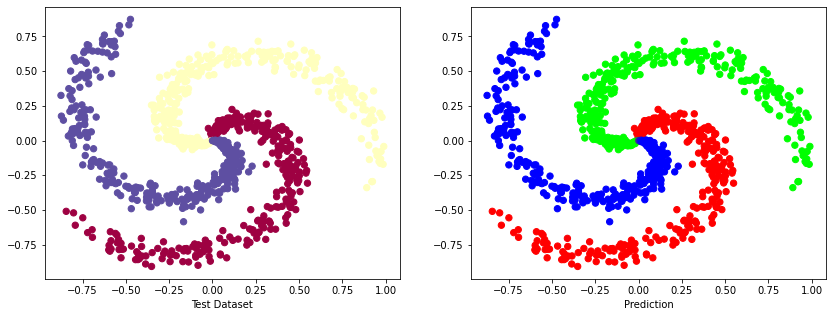

In [12]:
test_input = tf.Variable(test_x, dtype=tf.float32, name='input')
test_output = tf.Variable(test_y, dtype=tf.float32, name='output')

test_output_pred = model(test_input)
test_output_pred = tf.nn.softmax(test_output_pred, axis=-1)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.scatter(test_x[:, 0], test_x[:, 1], c=test_y, s=40, cmap=plt.cm.Spectral)
plt.xlabel("Test Dataset")
plt.subplot(1,2,2)
plt.scatter(test_x[:, 0], test_x[:, 1], c=test_output_pred.numpy(), s=40, cmap=plt.cm.Spectral)
plt.xlabel("Prediction")
plt.show()